In [22]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from matplotlib.animation import FuncAnimation
import seaborn as sns
import requests
from scipy.optimize import curve_fit
import math
register_matplotlib_converters()
sns.set_style('darkgrid')

chosen = 'Greece'
country_data = df[df['location']==chosen]

In [16]:
open('full_data.csv', 'wb').write(requests.get('https://covid.ourworldindata.org/data/ecdc/full_data.csv').content) # get the data from the URL

2777233

In [23]:
df = pd.read_csv('full_data.csv').set_index('date')
df.index = pd.to_datetime(df.index)

No handles with labels found to put in legend.


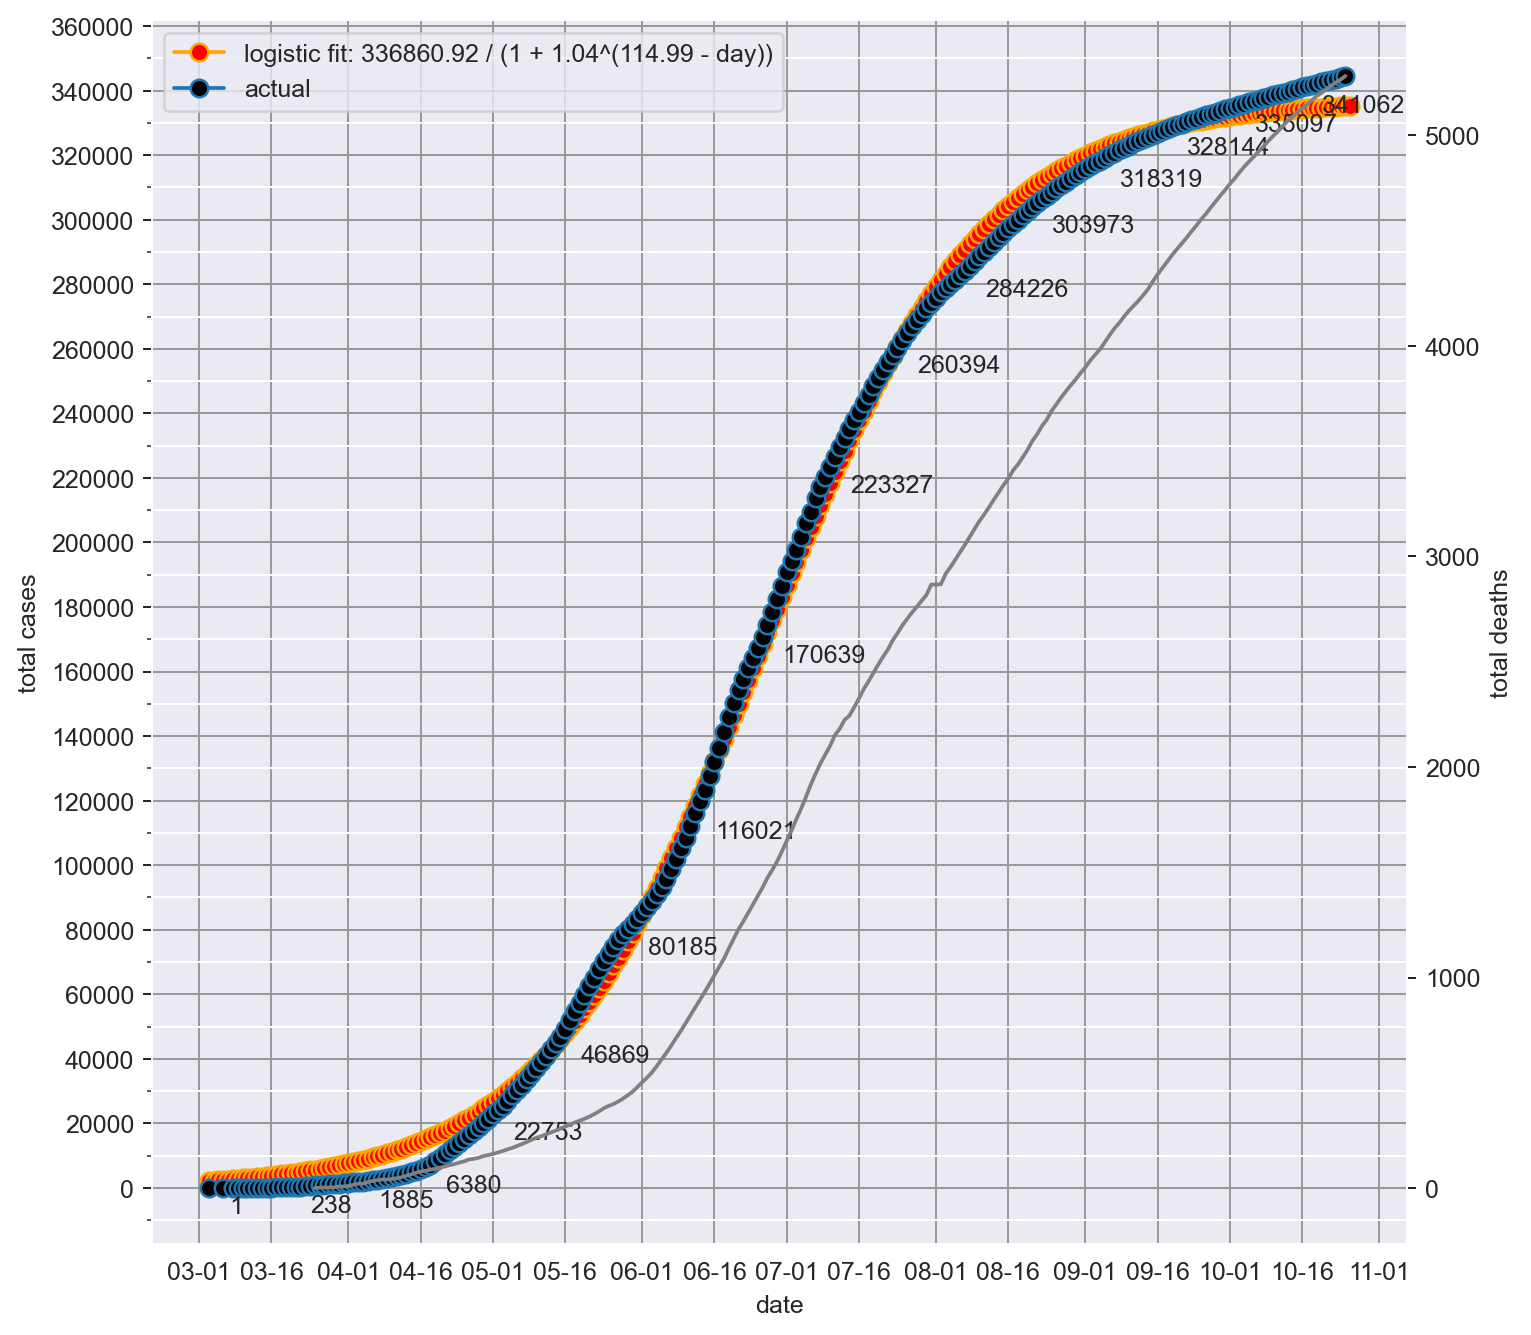

In [24]:
def exponential(x, a, b, c):
    return a * b**x + c

def logistic(x, L, k, a, ):
    return L / (1 + k**(a - x))

def get_prediction():
    x = pd.Series(to_plot.index).apply(pd.Timestamp.toordinal) - to_plot.index[0].toordinal()
    y = to_plot
    popt, pcov = curve_fit(func, x, y, maxfev = 15000, )
    return popt, func(np.arange(len(date_idx)), *popt)

def make_plot(daysep, casesep, annotsep):
    fig, ax = plt.subplots(figsize = (9,9), dpi=1080/(9/1.5))
    ax.plot(date_idx, prediction, color = 'orange', marker = 'o', markerfacecolor='red', markersize=7)
    ax.plot(to_plot, marker = 'o', markerfacecolor='black', markersize=7)

    ax.xaxis.set_major_locator(dates.DayLocator(daysep[0]))
    #ax.xaxis.set_minor_locator(dates.DayLocator(daysep[1]))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%d'))

    ax.yaxis.set_major_locator(ticker.MultipleLocator(casesep[0]))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(casesep[1]))
    plt.ylabel('total cases')
    plt.xlabel('date')
    plt.grid(which = 'major', color = '#999999')
    plt.grid(which = 'minor', color = '#ffffff')
    plt.legend()
    plt.legend([f'exponential fit: {round(popt[0], 2)} * {round(popt[1], 2)}^day + {round(popt[2], 2)}' if func is exponential else
                f'logistic fit: {round(popt[0], 2)} / (1 + {round(popt[1], 2)}^({round(popt[2], 2)} - day))',
                'actual'])
    #fig.tight_layout()
    
    ax2 = ax.twinx()
    ax2.plot(country_data['total_deaths'][:].dropna(), color = 'gray')
    ax2.xaxis.set_major_locator(dates.DayLocator(daysep[0]))
    #ax2.xaxis.set_minor_locator(dates.DayLocator(daysep[1]))
    ax2.xaxis.set_major_formatter(dates.DateFormatter('%m-%d'))
    ax2.grid(False)
    for x, y in list(to_plot.iteritems())[::annotsep]:
        ax.annotate(str(int(y)), xy=(x,y), xytext=(8,-10), textcoords='offset points')
    #for x, y in list(zip(date_idx[days-3:], prediction[days:]))[::annotsep]:
    #    ax.annotate(str(int(y)), xy=(x,y), xytext=(8,-10), textcoords='offset points', color = 'red')
    plt.ylabel('total deaths')
    
    plt.savefig('cases.png', pad_inches = 0, bbox_inches='tight')

to_plot = country_data['total_cases'][:].dropna() # can change to deaths or new cases
days = len(to_plot)
extension = 1
date_idx = pd.date_range(to_plot.index[0], to_plot.index[-1] + pd.Timedelta(days=extension))

func = logistic # logistic or exponential. fits were only accurate in the first few months of spreading
popt, prediction = get_prediction()

make_plot(((1, 16), (88888)), # major, minor
          (20000, 10000), # major, minor
          14) # sep of numbers next to the graph

In [25]:
df.loc[(df['location']==chosen) & (df.index > '2020-7-30') & (df.index < '2020-08-4'), 'new_deaths'] = [24, 26, 25, 26]

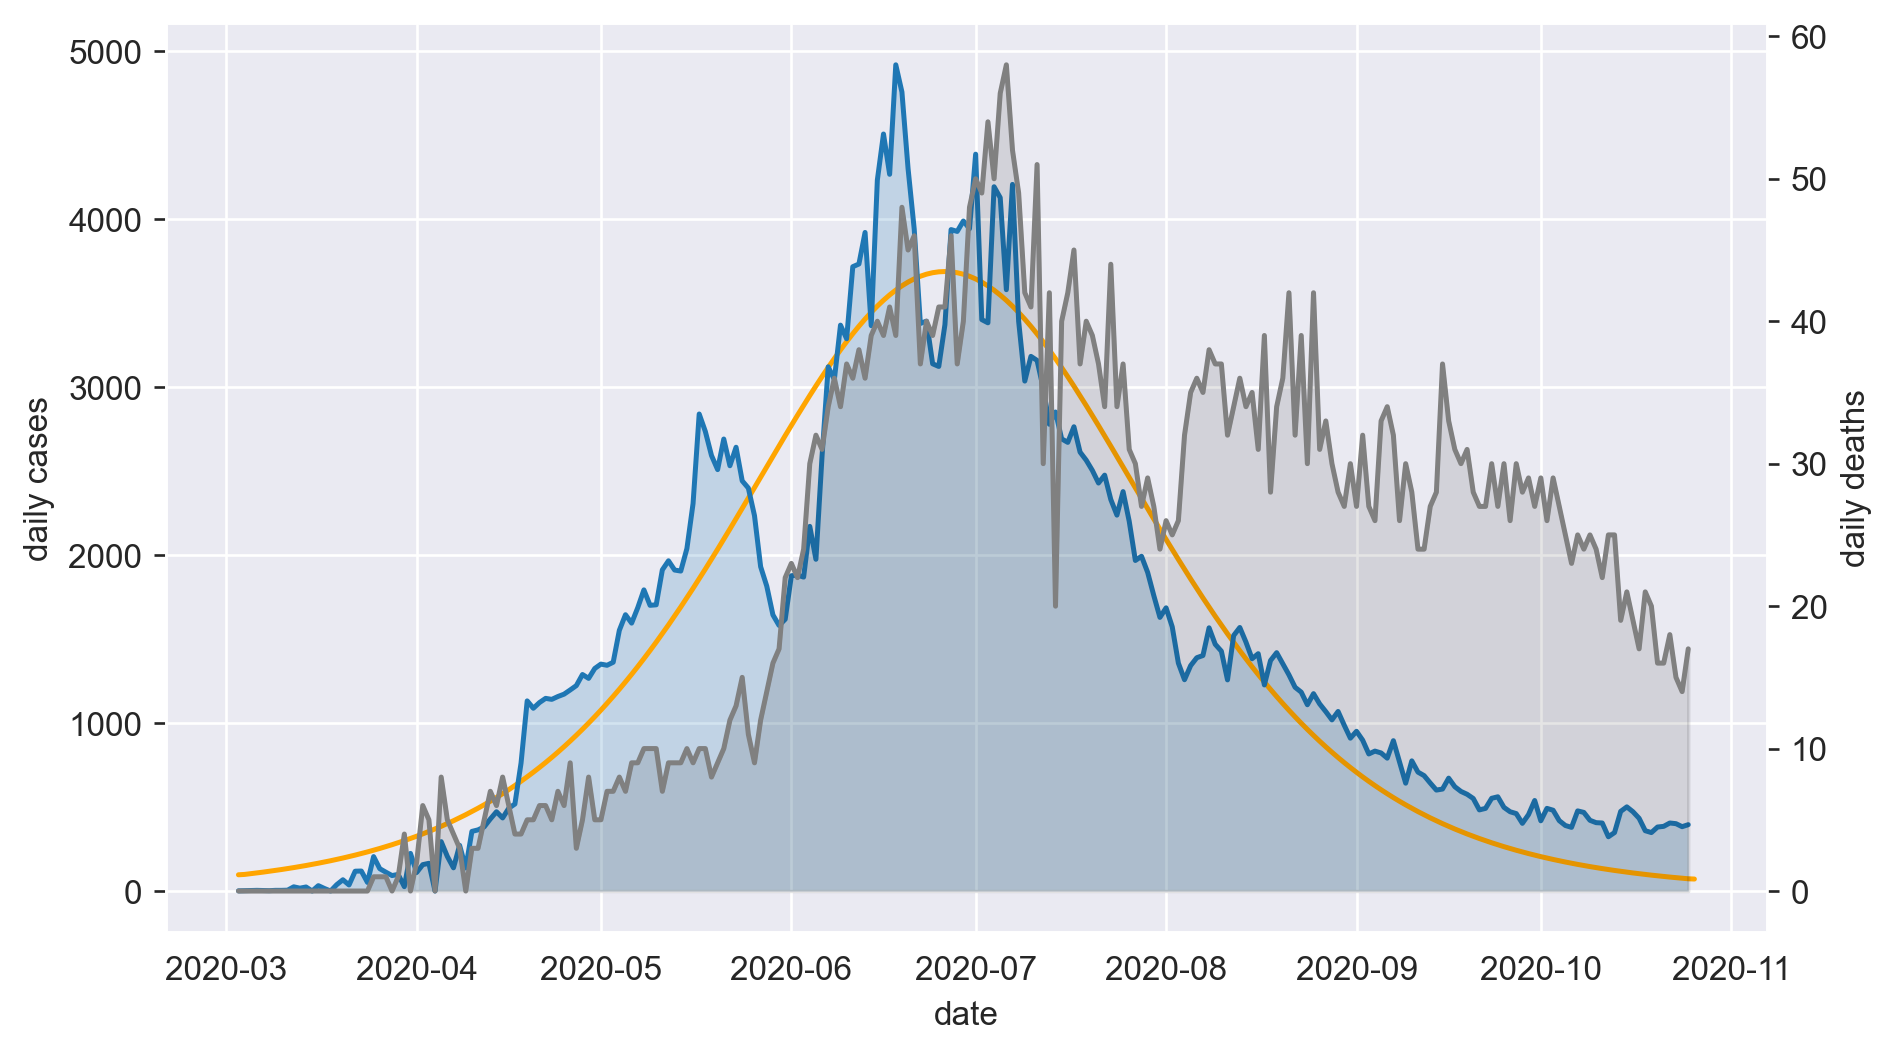

In [26]:
fig, ax1 = plt.subplots(figsize=(16/2,9/2), dpi = 1080/4.5)
plt.ylabel('daily cases')
plt.xlabel('date')
ax2 = ax1.twinx()
ax2.fill_between(country_data['new_deaths'][:].index, country_data['new_deaths'][:], color='black', interpolate=True, alpha=0.1)
ax2.plot(country_data['new_deaths'][:], color='gray')
plt.ylabel('daily deaths')

ax1.plot(date_idx, np.gradient(prediction), color = 'orange')
ax1.fill_between(country_data['new_cases'][:].index, country_data['new_cases'][:], interpolate=True, alpha=0.2)
ax1.plot(country_data['new_cases'][:])

ax2.grid(False)


plt.tight_layout()
plt.savefig('cases.png', pad_inches = 0, bbox_inches='tight')

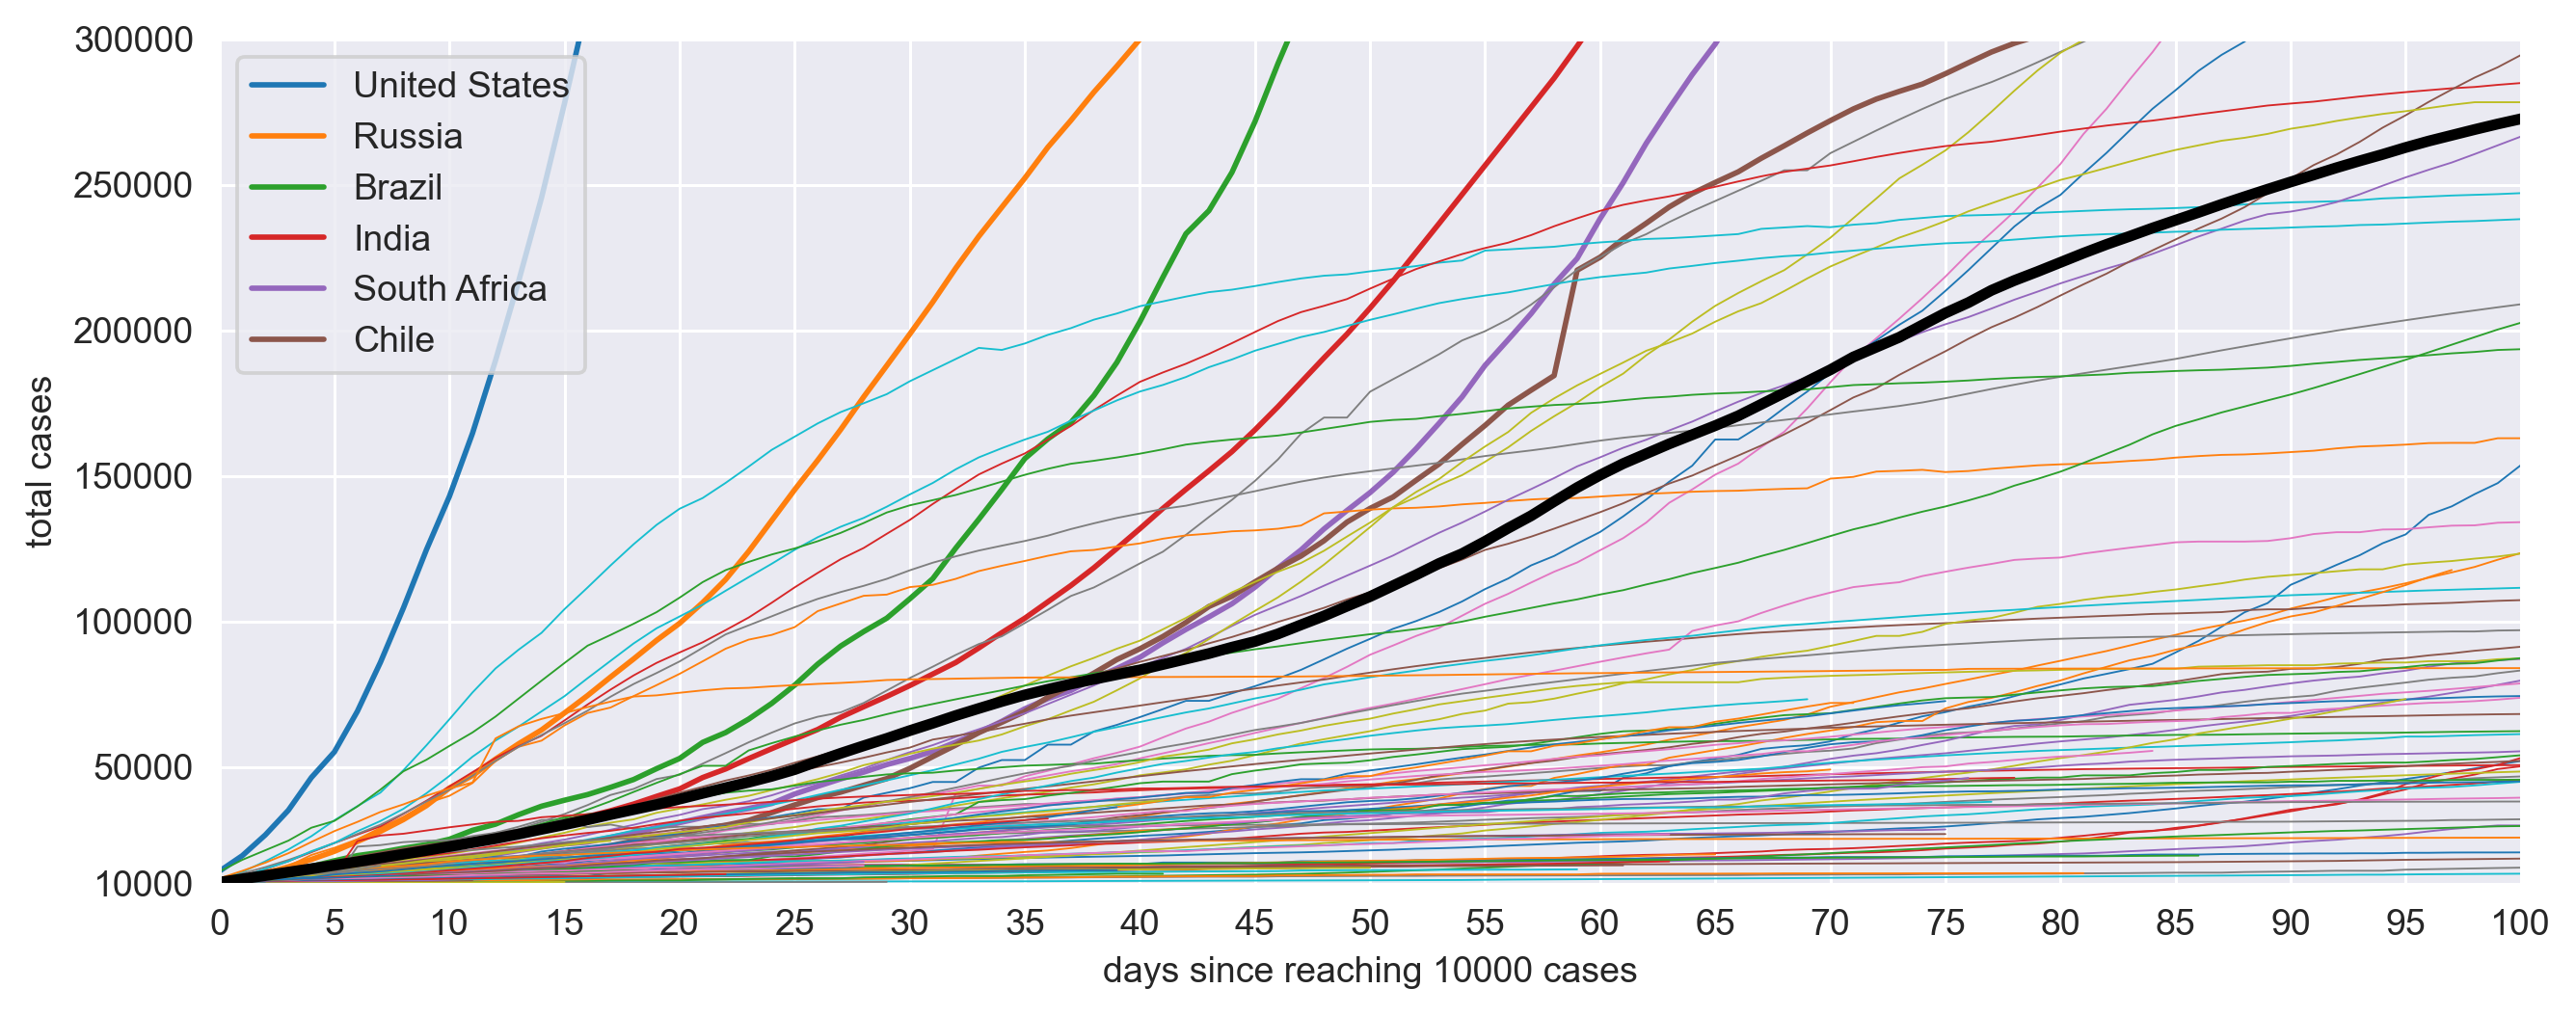

In [5]:
'''
Comparison of a chosen country (in black) with all countries from 1000 to 50000 cases
'''
weekly_df = {}
ymin = 10000
for country in df.location.unique():
    data = df[df.location == country]
    if data.iloc[-1].total_cases > ymin:
        weekly_df[country]=[]
        
for country in weekly_df:
    for _, row in df[df.location == country].iterrows():
        if row.total_cases > ymin:
            weekly_df[country].append(row.total_cases)
weekly_df.pop('World')
None

ymax = 300000

plt.figure(figsize = (10, 4), dpi=1080//4)
to_iter = sorted(weekly_df, key = lambda x: weekly_df[x][-1], reverse = True)
top = sorted([j for j in weekly_df if weekly_df[j][-1] >= ymax], key = lambda x: [i>=ymax for i in weekly_df[x]].index(True))[:6]

for i in top:
    plt.plot(weekly_df[i], linewidth = 1.5)
plt.legend(top)

for i in to_iter:
    if i not in top:
        plt.plot(weekly_df[i], linewidth = 0.5)
    
plt.plot(weekly_df[chosen], linewidth = 3, color = 'Black')

plt.ylim([ymin, ymax])
plt.xlim([0, 100])
plt.xticks(np.arange(0, 101, 5))
plt.xlabel('days since reaching 10000 cases')
plt.ylabel('total cases')
plt.yticks(np.append([10000], np.arange(50000, 300001, 50000)))
plt.tight_layout()
plt.savefig('plot4.png')


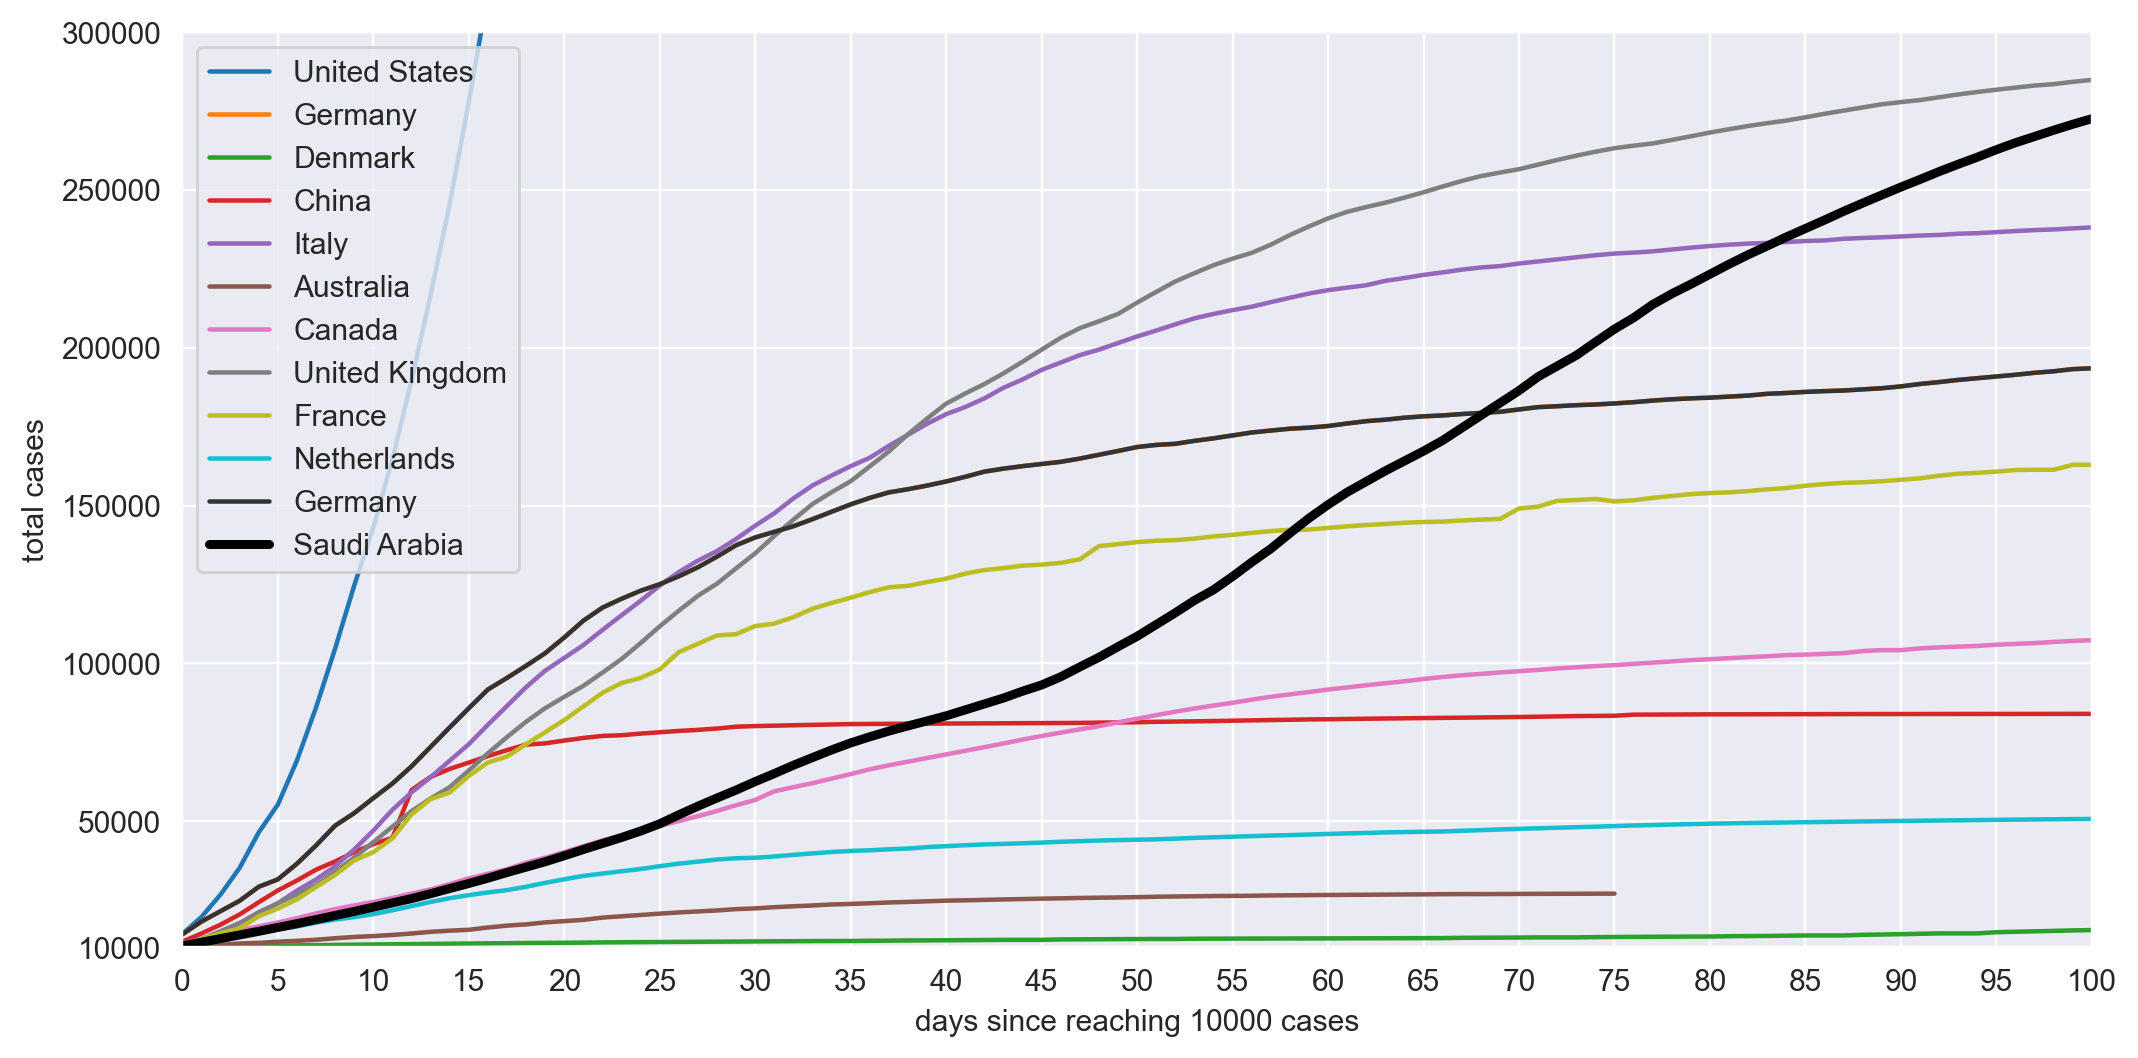

In [7]:
'''
Note: please run the above cell first to get the data ready.
Comparison of a chosen country (in black) with all countries from 5000 to 50000 cases
'''
days = 100

countries = ['United States', 'Germany', 'Denmark', 'China', 'Italy', 'Australia', 'Canada', 'United Kingdom', 'France', 'Netherlands', 'Germany', chosen]

plt.figure(figsize = (10, 5), dpi = 1080//5)
for country in countries[:-2]:
    plt.plot(weekly_df[country])
    
plt.plot(weekly_df['Germany'], color = '#333333')
plt.plot(weekly_df[chosen], linewidth = 3, color = 'BLACK')
plt.ylim([ymin, ymax])
plt.xlim([0, days])
plt.xticks(np.arange(0, days+1, 5))
plt.legend(countries)
plt.xlabel('days since reaching 10000 cases')
plt.ylabel('total cases')
plt.yticks(np.append([10000], np.arange(50000, 300001, 50000)))
plt.tight_layout()
plt.savefig('plot5.png')